# 0. Imports


In [114]:
import pickle
import random
import shap

from joblib import load, dump

import numpy as np

# import boruta as bt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn import preprocessing as pp
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# other ML models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# import xgboost as xgb
# import lightgbm as lgb
# import catboost as ctb


# Helper Functions


In [115]:
# plt.style.use("bmh"): This sets the matplotlib plot style to 'bmh'. 'bmh' is a popular style that stands for Bayesian Methods for Hackers, which is a book that uses this style in its plots.

# plt.rcParams["figure.figsize"] = [20, 10]: This sets the default figure size to be [20, 10].

# plt.rcParams["font.size"] = 24: This sets the default font size to 24.

# pd.options.display.max_columns = None: This line tells pandas to display all columns. By default, pandas limits the number of columns displayed.

# pd.options.display.max_rows = None: This line tells pandas to display all rows. By default, pandas limits the number of rows displayed.

# pd.set_option("display.float_format", lambda x: "%.4f" % x): This line sets the display format for floating-point numbers to 4 decimal places.

# pd.set_option("display.expand_frame_repr", False): This line tells pandas not to wrap repr(DataFrame) across multiple lines.

# sns.set(): This sets the default seaborn theme, color palette and font scale.


def settings():
    %matplotlib inline
    plt.style.use("bmh")
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.rcParams["font.size"] = 24
    # display( HTML( '') )
    pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    pd.set_option("display.float_format", lambda x: "%.4f" % x)
    pd.set_option("display.expand_frame_repr", False)
    sns.set()


settings()


def generate_report(df):
    # Create a DataFrame to hold the report
    report = pd.DataFrame(index=df.columns)

    # Identify the data type of each column
    report["DataType"] = df.dtypes

    # Identify whether each column is numerical or categorical
    report["FeatureType"] = [
        "categorical" if df[col].dtype in ["object", "category"] else "numerical"
        for col in df.columns
    ]

    # Calculate the percentage of non-null values for each column
    report["% Non-Null"] = df.count() / len(df) * 100

    # Calculate the percentage of null values for each column
    report["% Null"] = df.isnull().sum() / len(df) * 100

    # Return the report
    return report


# Define the scoring function
def scoring_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Read in Data && Drop 1st Column (Inappropriate Index)


In [116]:
# Mount Google Drive in Colab
# from google.colab import drive
# drive.mount('/content/drive')

# load the data
# file_path1 = ('/content/drive/My Drive/Colab Notebooks/chevron/training.csv')

file_path1 = "train/training.csv"


In [117]:
# import pandas as pd
# import numpy as np

df = pd.read_csv(file_path1)

df = df.drop(["Unnamed: 0"], axis=1)

df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,ffs_frac_type,proppant_intensity,frac_fluid_intensity,average_stage_length,average_proppant_per_stage,average_frac_fluid_per_stage,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,pad_id,relative_well_position,batch_frac_classification,well_family_relationship,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,1383493.7510,717329.2368,1382854.5640,712767.3700,1121,3963.5827,NaN,76000.0000,NaN,8712.5984,NaN,19.1746,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,102604,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383030.6780,714796.3610,1382668.9120,712798.4321,46.6230
1,1380344.0350,711916.2732,1379738.4290,707860.5643,1022,3179.1339,NaN,113000.0000,561096.3964,8627.9528,NaN,35.5443,176.4935,NaN,NaN,NaN,0.2014,4.9655,1.0000,108497,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379965.1260,709541.7145,1379630.0250,707907.6708,59.7500
2,1379915.8950,717845.0063,1379274.6440,713471.9952,1304,3810.0394,12.0000,286571.4286,1621423.5130,8801.1811,NaN,75.2148,425.5661,317.5033,23880.9524,135118.6261,0.1767,5.6580,1.0000,108526,Standalone Well,Non-Batch Frac,Standalone Well,Primary Frac,92.0000,1379357.2500,715381.2327,1378960.3720,713530.4490,10.7857
3,1383567.4430,706640.2010,1382891.4770,702068.3838,1022,3723.4252,11.0000,106878.9286,437713.4249,8635.8268,NaN,28.7045,117.5567,338.4932,9716.2662,39792.1295,0.2442,4.0954,1.0000,105631,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383099.6100,704058.8508,1382727.2990,702098.4882,123.7976
4,1378962.5850,702623.9787,1379643.5460,707204.9131,1022,3811.0236,NaN,112789.7143,622980.1559,8664.3701,NaN,29.5956,163.4679,NaN,NaN,NaN,0.1810,5.5234,1.0000,103717,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379546.4140,705150.7519,1379987.4870,707123.7258,102.3095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.5930,978921.8705,1432758.0320,979984.5869,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN,NaN
29688,1513299.1890,976157.4486,1519890.0720,975148.4820,1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN,NaN
29689,1458652.1420,972862.2346,1453129.8890,973195.0998,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN,NaN
29690,1463417.4360,972485.8276,1468807.7650,971564.9743,1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
df.columns


Index(['surface_x', 'surface_y', 'bh_x', 'bh_y', 'standardized_operator_name',
       'gross_perforated_length', 'number_of_stages', 'total_proppant',
       'total_fluid', 'true_vertical_depth', 'ffs_frac_type',
       'proppant_intensity', 'frac_fluid_intensity', 'average_stage_length',
       'average_proppant_per_stage', 'average_frac_fluid_per_stage',
       'proppant_to_frac_fluid_ratio', 'frac_fluid_to_proppant_ratio',
       'bin_lateral_length', 'pad_id', 'relative_well_position',
       'batch_frac_classification', 'well_family_relationship', 'frac_type',
       'frac_seasoning', 'horizontal_midpoint_x', 'horizontal_midpoint_y',
       'horizontal_toe_x', 'horizontal_toe_y', 'OilPeakRate'],
      dtype='object')

In [119]:
generate_report(df)


,DataType,FeatureType,% Non-Null,% Null
surface_x,float64,numerical,100.0000,0.0000
surface_y,float64,numerical,100.0000,0.0000
bh_x,float64,numerical,92.9712,7.0288
bh_y,float64,numerical,92.9712,7.0288
standardized_operator_name,int64,numerical,100.0000,0.0000
gross_perforated_length,float64,numerical,74.5487,25.4513
number_of_stages,float64,numerical,9.2685,90.7315
total_proppant,float64,numerical,64.2597,35.7403
total_fluid,float64,numerical,64.2463,35.7537
true_vertical_depth,float64,numerical,94.9650,5.0350


# EDA


In [121]:
result = df.groupby("standardized_operator_name")["OilPeakRate"].agg(["count"])
result = result.reset_index()
sorted_result = result.sort_values(by="count", ascending=False)
sorted_result


,standardized_operator_name,count
209,1213,1886
141,1145,1202
87,1091,1018
16,1018,995
117,1121,946
...,...,...
173,1177,0
172,1176,0
171,1175,0
164,1168,0


FixedFormatter should only be used together with FixedLocator


[Text(0, 0, '1018'),
 Text(1, 0, '1025'),
 Text(2, 0, '1028'),
 Text(3, 0, '1030'),
 Text(4, 0, '1041'),
 Text(5, 0, '1049'),
 Text(6, 0, '1053'),
 Text(7, 0, '1086'),
 Text(8, 0, '1091'),
 Text(9, 0, '1121'),
 Text(10, 0, '1144'),
 Text(11, 0, '1145'),
 Text(12, 0, '1172'),
 Text(13, 0, '1213'),
 Text(14, 0, '1221'),
 Text(15, 0, '1272'),
 Text(16, 0, '1311'),
 Text(17, 0, '1325'),
 Text(18, 0, '1343'),
 Text(19, 0, '1344'),
 Text(20, 0, '1349')]

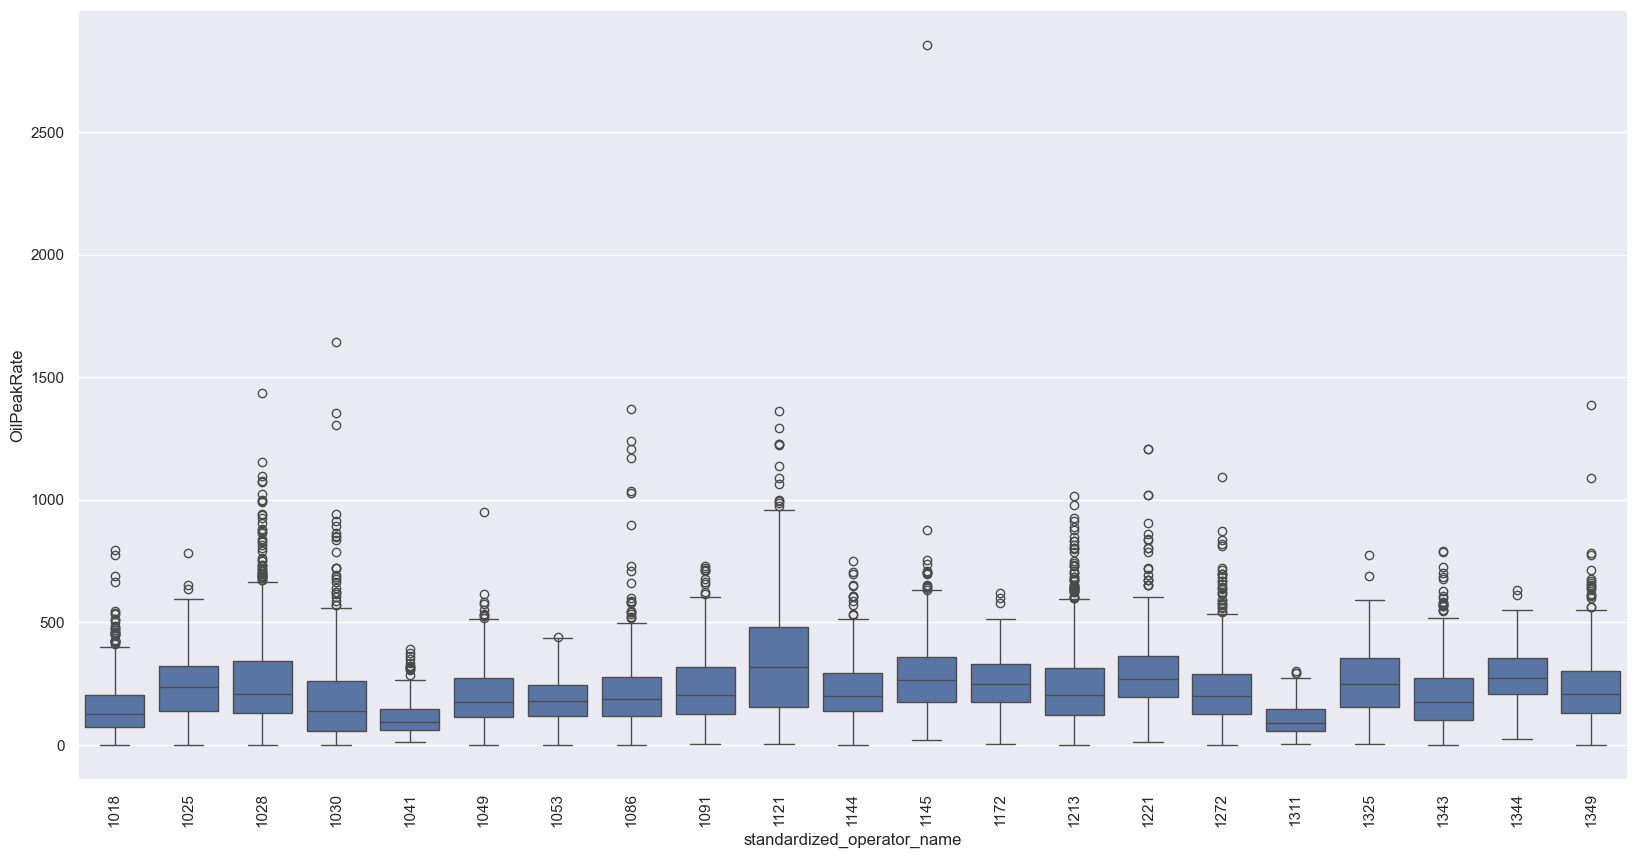

In [122]:
top_20_operator = sorted_result[:21]["standardized_operator_name"]
ax = sns.boxplot(
    x="standardized_operator_name",
    y="OilPeakRate",
    data=df[df["standardized_operator_name"].isin(top_20_operator)],
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


# Drop High > 49% Null Columns


In [123]:
# Drop all following rows with > 49% null values:
# number_of_stages
# ffs_frac_type
# average_stage_length
# average_proppant_per_stage
# average_frac_fluid_per_stage
# frac_seasoning

# Save a copy of the current DataFrame
df_old = df.copy()

# Calculate the threshold for >49% null values
thresh = len(df) * 0.51

# Drop columns with >49% null values
df = df.dropna(thresh=thresh, axis=1)

df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,pad_id,relative_well_position,batch_frac_classification,well_family_relationship,frac_type,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,1383493.7510,717329.2368,1382854.5640,712767.3700,1121,3963.5827,76000.0000,NaN,8712.5984,19.1746,NaN,NaN,NaN,1.0000,102604,Standalone Well,Unknown,Standalone Well,Primary Frac,1383030.6780,714796.3610,1382668.9120,712798.4321,46.6230
1,1380344.0350,711916.2732,1379738.4290,707860.5643,1022,3179.1339,113000.0000,561096.3964,8627.9528,35.5443,176.4935,0.2014,4.9655,1.0000,108497,Outer Well,Unknown,Infill Child Well,Primary Frac,1379965.1260,709541.7145,1379630.0250,707907.6708,59.7500
2,1379915.8950,717845.0063,1379274.6440,713471.9952,1304,3810.0394,286571.4286,1621423.5130,8801.1811,75.2148,425.5661,0.1767,5.6580,1.0000,108526,Standalone Well,Non-Batch Frac,Standalone Well,Primary Frac,1379357.2500,715381.2327,1378960.3720,713530.4490,10.7857
3,1383567.4430,706640.2010,1382891.4770,702068.3838,1022,3723.4252,106878.9286,437713.4249,8635.8268,28.7045,117.5567,0.2442,4.0954,1.0000,105631,Standalone Well,Unknown,Standalone Well,Primary Frac,1383099.6100,704058.8508,1382727.2990,702098.4882,123.7976
4,1378962.5850,702623.9787,1379643.5460,707204.9131,1022,3811.0236,112789.7143,622980.1559,8664.3701,29.5956,163.4679,0.1810,5.5234,1.0000,103717,Outer Well,Unknown,Infill Child Well,Primary Frac,1379546.4140,705150.7519,1379987.4870,707123.7258,102.3095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.5930,978921.8705,1432758.0320,979984.5869,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN
29688,1513299.1890,976157.4486,1519890.0720,975148.4820,1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN
29689,1458652.1420,972862.2346,1453129.8890,973195.0998,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN
29690,1463417.4360,972485.8276,1468807.7650,971564.9743,1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117032,NaN,NaN,NaN,Primary Frac,NaN,NaN,NaN,NaN,NaN


# Drop 3 Redundant Categorical Columns + Fract_Type + Pad_ID


In [125]:
# Make a copy of the current DataFrame
df_copy_1 = df.copy()

# Drop the specified columns
df = df.drop(
    columns=[
        "relative_well_position",
        "batch_frac_classification",
        "well_family_relationship",
        "frac_type",
        "pad_id",
    ]
)

df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,1383493.7510,717329.2368,1382854.5640,712767.3700,1121,3963.5827,76000.0000,NaN,8712.5984,19.1746,NaN,NaN,NaN,1.0000,1383030.6780,714796.3610,1382668.9120,712798.4321,46.6230
1,1380344.0350,711916.2732,1379738.4290,707860.5643,1022,3179.1339,113000.0000,561096.3964,8627.9528,35.5443,176.4935,0.2014,4.9655,1.0000,1379965.1260,709541.7145,1379630.0250,707907.6708,59.7500
2,1379915.8950,717845.0063,1379274.6440,713471.9952,1304,3810.0394,286571.4286,1621423.5130,8801.1811,75.2148,425.5661,0.1767,5.6580,1.0000,1379357.2500,715381.2327,1378960.3720,713530.4490,10.7857
3,1383567.4430,706640.2010,1382891.4770,702068.3838,1022,3723.4252,106878.9286,437713.4249,8635.8268,28.7045,117.5567,0.2442,4.0954,1.0000,1383099.6100,704058.8508,1382727.2990,702098.4882,123.7976
4,1378962.5850,702623.9787,1379643.5460,707204.9131,1022,3811.0236,112789.7143,622980.1559,8664.3701,29.5956,163.4679,0.1810,5.5234,1.0000,1379546.4140,705150.7519,1379987.4870,707123.7258,102.3095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.5930,978921.8705,1432758.0320,979984.5869,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29688,1513299.1890,976157.4486,1519890.0720,975148.4820,1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29689,1458652.1420,972862.2346,1453129.8890,973195.0998,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29690,1463417.4360,972485.8276,1468807.7650,971564.9743,1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
generate_report(df)


,DataType,FeatureType,% Non-Null,% Null
surface_x,float64,numerical,100.0000,0.0000
surface_y,float64,numerical,100.0000,0.0000
bh_x,float64,numerical,92.9712,7.0288
bh_y,float64,numerical,92.9712,7.0288
standardized_operator_name,int64,numerical,100.0000,0.0000
gross_perforated_length,float64,numerical,74.5487,25.4513
total_proppant,float64,numerical,64.2597,35.7403
total_fluid,float64,numerical,64.2463,35.7537
true_vertical_depth,float64,numerical,94.9650,5.0350
proppant_intensity,float64,numerical,63.8926,36.1074


In [127]:
numerical_cols = df.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
categorical_cols = df.select_dtypes(
    include=["object", "category"]
).columns.tolist()
numerical_cols.remove("standardized_operator_name")
categorical_cols.append("standardized_operator_name")
numerical_cols, categorical_cols


(['surface_x',
  'surface_y',
  'bh_x',
  'bh_y',
  'gross_perforated_length',
  'total_proppant',
  'total_fluid',
  'true_vertical_depth',
  'proppant_intensity',
  'frac_fluid_intensity',
  'proppant_to_frac_fluid_ratio',
  'frac_fluid_to_proppant_ratio',
  'bin_lateral_length',
  'horizontal_midpoint_x',
  'horizontal_midpoint_y',
  'horizontal_toe_x',
  'horizontal_toe_y',
  'OilPeakRate'],
 ['standardized_operator_name'])

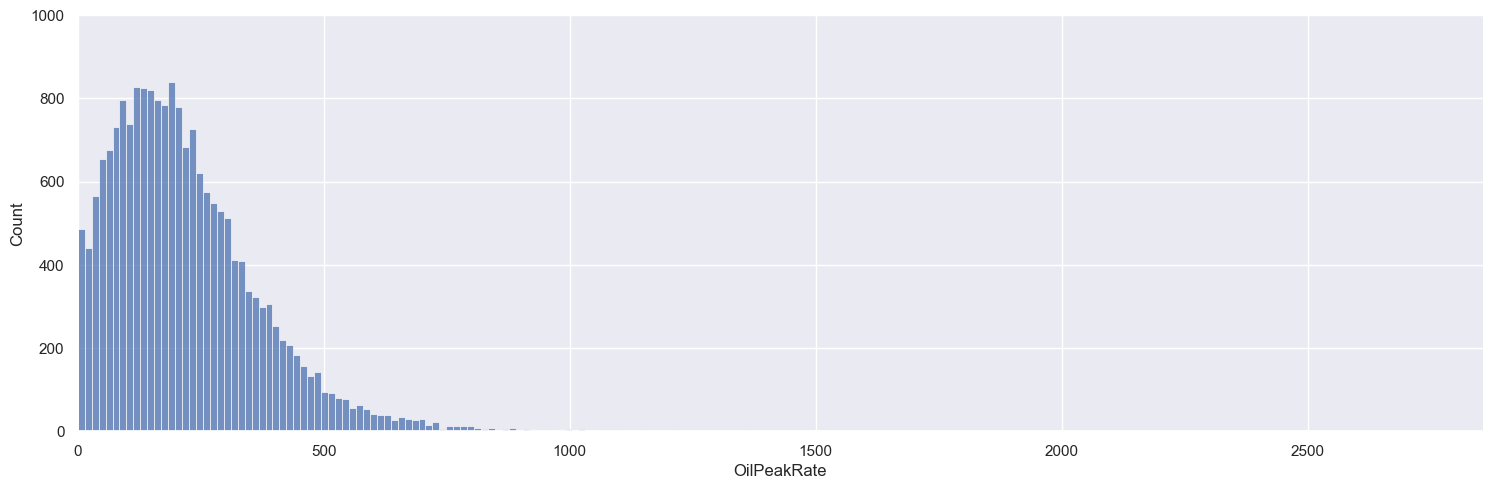

In [128]:
# Set the size of the figure
height = 5  # Height of the figure in inches
aspect = 3  # Aspect ratio of the figure (width/height)

# Create the plot
plot = sns.displot(df["OilPeakRate"], height=height, aspect=aspect)

# Set x and y axis limits
plot.set(xlim=(0, df["OilPeakRate"].max()), ylim=(0, 1000))

# Show the plot
plt.show()


# Impute Missing Values


In [130]:
df = df.replace([np.inf, -np.inf], np.nan).fillna(method="ffill")


In [131]:
# handle missing value
# from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

# df = pd.concat([df_numerical, df_categorical], axis=1)
df[:] = knn_imputer.fit_transform(df)
df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,1383493.7510,717329.2368,1382854.5640,712767.3700,1121,3963.5827,76000.0000,551299.2877,8712.5984,19.1746,130.1346,0.1565,6.4443,1.0000,1383030.6780,714796.3610,1382668.9120,712798.4321,46.6230
1,1380344.0350,711916.2732,1379738.4290,707860.5643,1022,3179.1339,113000.0000,561096.3964,8627.9528,35.5443,176.4935,0.2014,4.9655,1.0000,1379965.1260,709541.7145,1379630.0250,707907.6708,59.7500
2,1379915.8950,717845.0063,1379274.6440,713471.9952,1304,3810.0394,286571.4286,1621423.5130,8801.1811,75.2148,425.5661,0.1767,5.6580,1.0000,1379357.2500,715381.2327,1378960.3720,713530.4490,10.7857
3,1383567.4430,706640.2010,1382891.4770,702068.3838,1022,3723.4252,106878.9286,437713.4249,8635.8268,28.7045,117.5567,0.2442,4.0954,1.0000,1383099.6100,704058.8508,1382727.2990,702098.4882,123.7976
4,1378962.5850,702623.9787,1379643.5460,707204.9131,1022,3811.0236,112789.7143,622980.1559,8664.3701,29.5956,163.4679,0.1810,5.5234,1.0000,1379546.4140,705150.7519,1379987.4870,707123.7258,102.3095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.5930,978921.8705,1432758.0320,979984.5869,1050,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143
29688,1513299.1890,976157.4486,1519890.0720,975148.4820,1159,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143
29689,1458652.1420,972862.2346,1453129.8890,973195.0998,1050,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143
29690,1463417.4360,972485.8276,1468807.7650,971564.9743,1153,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143


# Add New Features (Feature Engineering)


In [132]:
# Add 4 new features:
# - well_trajectory_length
# - proppant_efficiency
# - fluid_efficiency
# - well_inclination

# Well Trajectory Length (3D)
df["well_trajectory_length_f"] = np.sqrt(
    (df["surface_x"] - df["bh_x"]) ** 2
    + (df["surface_y"] - df["bh_y"]) ** 2
    + (df["true_vertical_depth"]) ** 2
)

# Inclination
df["well_inclination_f"] = np.arccos(
    df["true_vertical_depth"] / df["well_trajectory_length_f"]
)

# Proppant and Fluid Efficiency
df["proppant_efficiency_f"] = df["total_proppant"] / df["true_vertical_depth"]
df["fluid_efficiency_f"] = df["total_fluid"] / df["true_vertical_depth"]


df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate,well_trajectory_length_f,well_inclination_f,proppant_efficiency_f,fluid_efficiency_f
0,1383493.7510,717329.2368,1382854.5640,712767.3700,1121,3963.5827,76000.0000,551299.2877,8712.5984,19.1746,130.1346,0.1565,6.4443,1.0000,1383030.6780,714796.3610,1382668.9120,712798.4321,46.6230,9855.3823,0.4864,8.7230,63.2761
1,1380344.0350,711916.2732,1379738.4290,707860.5643,1022,3179.1339,113000.0000,561096.3964,8627.9528,35.5443,176.4935,0.2014,4.9655,1.0000,1379965.1260,709541.7145,1379630.0250,707907.6708,59.7500,9552.8583,0.4437,13.0970,65.0324
2,1379915.8950,717845.0063,1379274.6440,713471.9952,1304,3810.0394,286571.4286,1621423.5130,8801.1811,75.2148,425.5661,0.1767,5.6580,1.0000,1379357.2500,715381.2327,1378960.3720,713530.4490,10.7857,9848.6150,0.4654,32.5606,184.2279
3,1383567.4430,706640.2010,1382891.4770,702068.3838,1022,3723.4252,106878.9286,437713.4249,8635.8268,28.7045,117.5567,0.2442,4.0954,1.0000,1383099.6100,704058.8508,1382727.2990,702098.4882,123.7976,9794.6897,0.4914,12.3762,50.6858
4,1378962.5850,702623.9787,1379643.5460,707204.9131,1022,3811.0236,112789.7143,622980.1559,8664.3701,29.5956,163.4679,0.1810,5.5234,1.0000,1379546.4140,705150.7519,1379987.4870,707123.7258,102.3095,9824.4581,0.4909,13.0176,71.9014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.5930,978921.8705,1432758.0320,979984.5869,1050,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143,9938.6327,1.0066,41.1776,214.6224
29688,1513299.1890,976157.4486,1519890.0720,975148.4820,1159,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143,8526.8141,0.8978,41.1776,214.6224
29689,1458652.1420,972862.2346,1453129.8890,973195.0998,1050,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143,7671.6937,0.8054,41.1776,214.6224
29690,1463417.4360,972485.8276,1468807.7650,971564.9743,1153,4242.1260,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,1.0000,1426278.7860,1018923.9020,1512679.8380,975523.9692,12.2143,7625.7737,0.7996,41.1776,214.6224


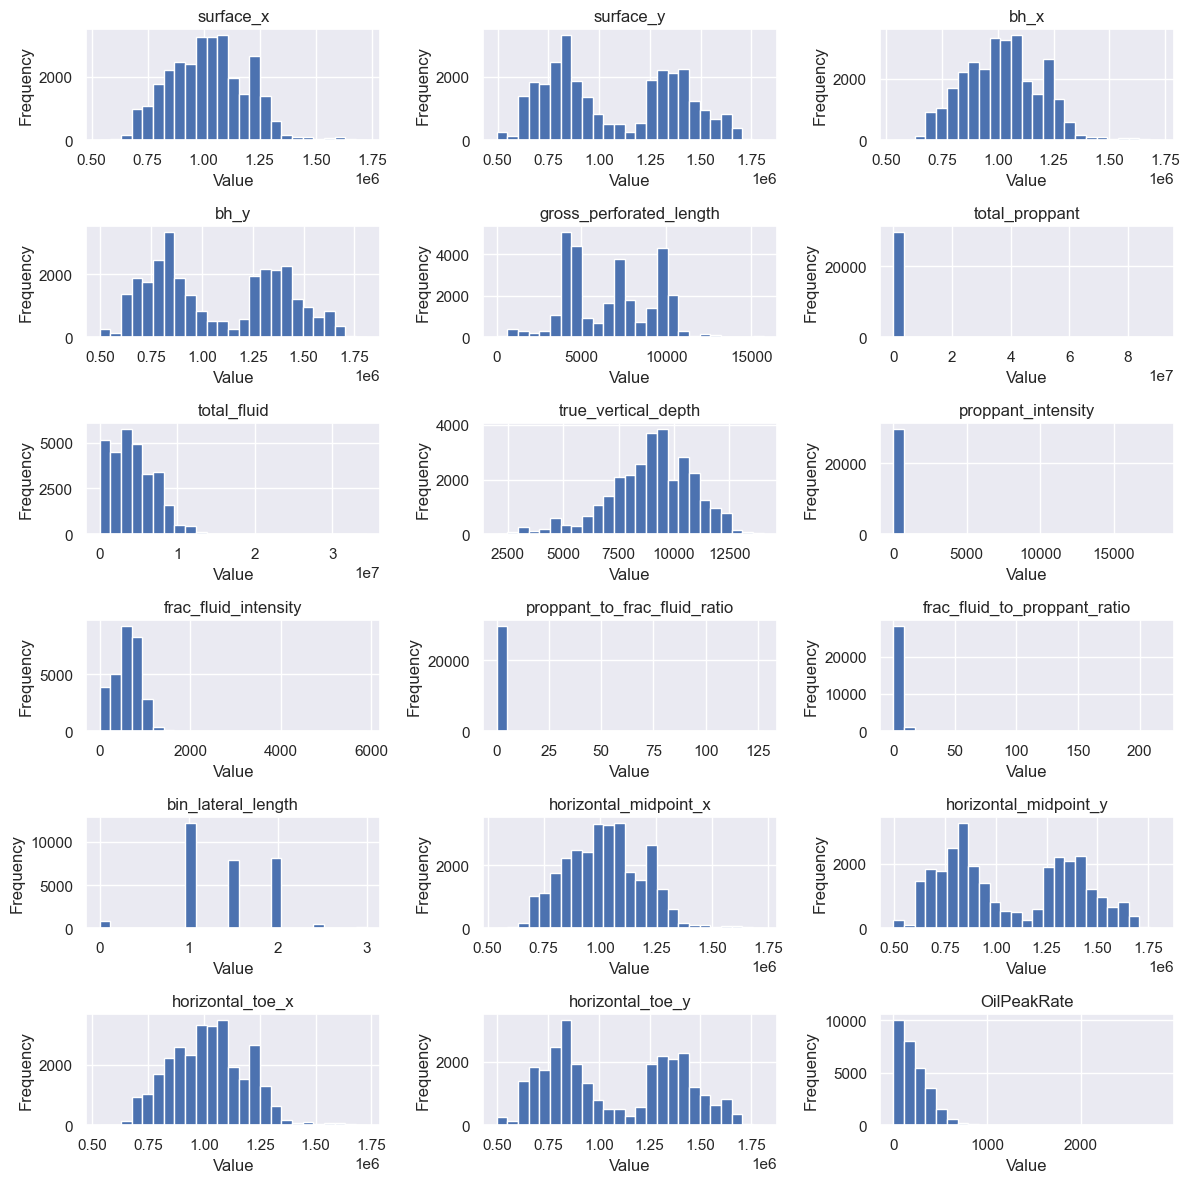

In [133]:
# Set the figure size to 20x20 inches and create a 6x3 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 12))


# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numerical column
for i, col in enumerate(numerical_cols):
    df[col].hist(bins=25, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots (if numerical_cols has less than 18 columns)
for ax in axes[len(numerical_cols) :]:
    ax.remove()

# Adjust the layout so that labels and titles don't overlap
plt.tight_layout()

# Show the plot
plt.show()


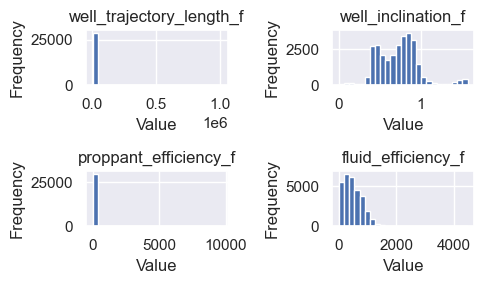

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'numerical_cols' contains your numerical column names

# List of new features to plot
new_features = [
    "well_trajectory_length_f",
    "well_inclination_f",
    "proppant_efficiency_f",
    "fluid_efficiency_f",
]

# Add the new features to the existing numerical columns for plotting
cols_to_plot = new_features

# Set the figure size to 12x12 inches and create a 2X2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 3))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numerical column including the new features
for i, col in enumerate(cols_to_plot):
    # Only plot if the current index is less than the number of axes
    if i < len(axes):
        df[col].hist(bins=25, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Frequency")
    else:
        # If there are more columns to plot than axes, break the loop
        break

# Remove any empty subplots if cols_to_plot has less than the number of subplots
for ax in axes[len(cols_to_plot) :]:
    ax.remove()

# Adjust the layout so that labels and titles don't overlap
plt.tight_layout()

# Show the plot
plt.show()


# Scaling Features


In [135]:
numerical_cols = df.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

categorical_cols = df.select_dtypes(
    include=["object", "category"]
).columns.tolist()

print(f"List of Numerical Columns: {numerical_cols}")
print(f"List of Categorical Columns: {categorical_cols}")


List of Numerical Columns: ['surface_x', 'surface_y', 'bh_x', 'bh_y', 'standardized_operator_name', 'gross_perforated_length', 'total_proppant', 'total_fluid', 'true_vertical_depth', 'proppant_intensity', 'frac_fluid_intensity', 'proppant_to_frac_fluid_ratio', 'frac_fluid_to_proppant_ratio', 'bin_lateral_length', 'horizontal_midpoint_x', 'horizontal_midpoint_y', 'horizontal_toe_x', 'horizontal_toe_y', 'OilPeakRate', 'well_trajectory_length_f', 'well_inclination_f', 'proppant_efficiency_f', 'fluid_efficiency_f']
List of Categorical Columns: []


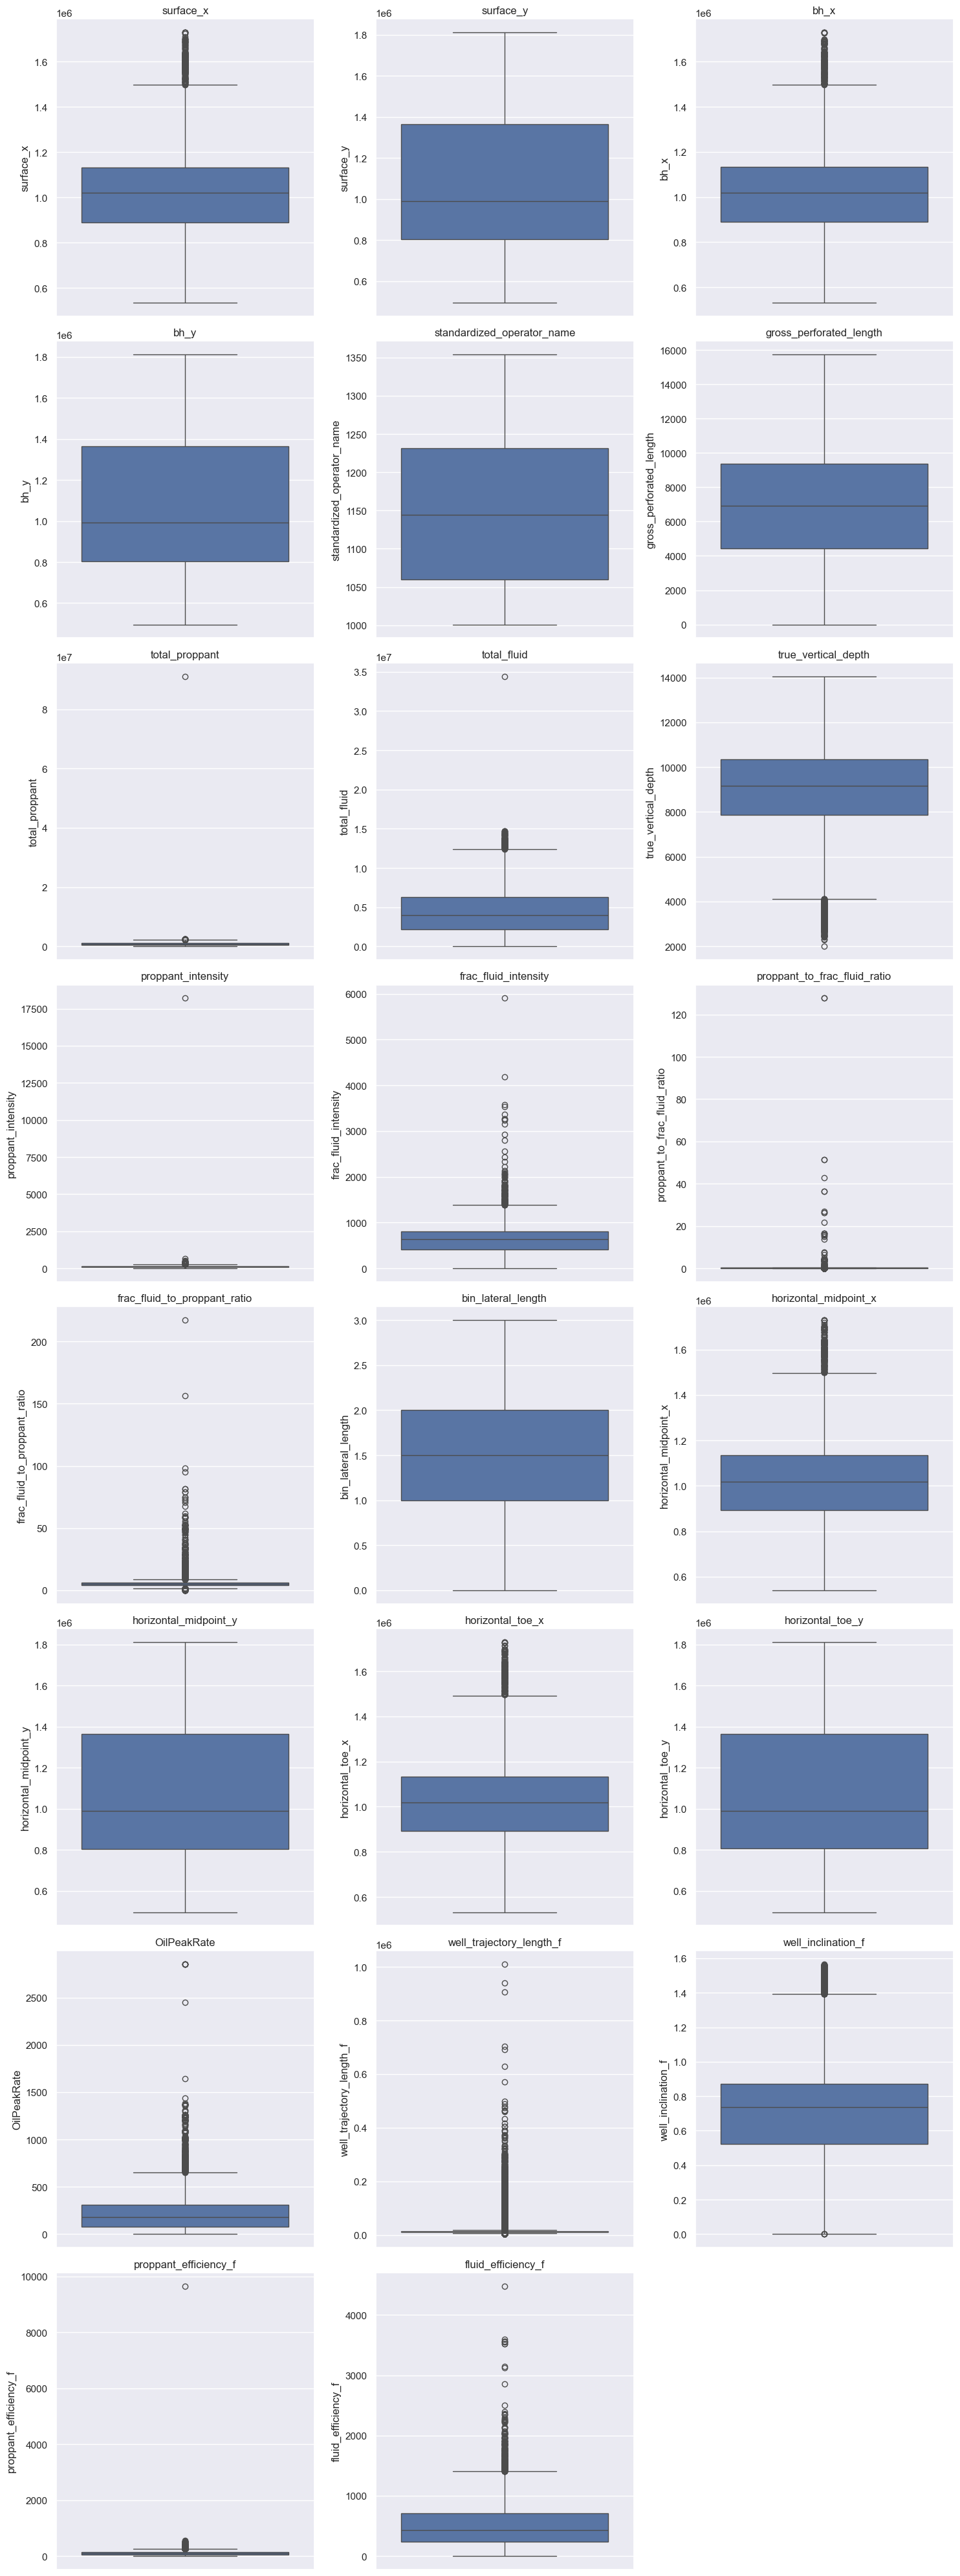

In [136]:
# Assuming df is your DataFrame
# Select only the numerical columns
df_numerical = df.select_dtypes(include=["float64", "int64"])

# Determine the number of rows needed for subplots
n_rows = len(df_numerical.columns) // 3 + (len(df_numerical.columns) % 3 > 0)
n_cols = 3

# Create a figure for the subplots
plt.figure(figsize=(n_cols * 5, n_rows * 5))

# Create a boxplot for each numerical column
for i, column in enumerate(df_numerical.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_numerical[column])
    plt.title(column)

plt.tight_layout()
plt.show()


In [137]:
# Min-Max Scaling (no outliers)

surface_y = pp.MinMaxScaler()
df["surface_y"] = surface_y.fit_transform(df[["surface_y"]].values)

bh_y = pp.MinMaxScaler()
df["bh_y"] = bh_y.fit_transform(df[["bh_y"]].values)

standardized_operator_name = pp.MinMaxScaler()
df["standardized_operator_name"] = standardized_operator_name.fit_transform(
    df[["standardized_operator_name"]].values
)

gross_perforated_length = pp.MinMaxScaler()
df["gross_perforated_length"] = gross_perforated_length.fit_transform(
    df[["gross_perforated_length"]].values
)


bin_lateral_length = pp.MinMaxScaler()
df["bin_lateral_length"] = bin_lateral_length.fit_transform(
    df[["bin_lateral_length"]].values
)


horizontal_midpoint_y = pp.MinMaxScaler()
df["horizontal_midpoint_y"] = horizontal_midpoint_y.fit_transform(
    df[["horizontal_midpoint_y"]].values
)


horizontal_toe_y = pp.MinMaxScaler()
df["horizontal_toe_y"] = horizontal_toe_y.fit_transform(
    df[["horizontal_toe_y"]].values
)

# Print dataframe after min-max scaling all features with minimal outliers
df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate,well_trajectory_length_f,well_inclination_f,proppant_efficiency_f,fluid_efficiency_f
0,1383493.7510,0.1688,1382854.5640,0.1649,0.3399,0.2518,76000.0000,551299.2877,8712.5984,19.1746,130.1346,0.1565,6.4443,0.3333,1383030.6780,0.1662,1382668.9120,0.1649,46.6230,9855.3823,0.4864,8.7230,63.2761
1,1380344.0350,0.1647,1379738.4290,0.1612,0.0595,0.2019,113000.0000,561096.3964,8627.9528,35.5443,176.4935,0.2014,4.9655,0.3333,1379965.1260,0.1622,1379630.0250,0.1612,59.7500,9552.8583,0.4437,13.0970,65.0324
2,1379915.8950,0.1692,1379274.6440,0.1654,0.8584,0.2420,286571.4286,1621423.5130,8801.1811,75.2148,425.5661,0.1767,5.6580,0.3333,1379357.2500,0.1667,1378960.3720,0.1655,10.7857,9848.6150,0.4654,32.5606,184.2279
3,1383567.4430,0.1607,1382891.4770,0.1568,0.0595,0.2365,106878.9286,437713.4249,8635.8268,28.7045,117.5567,0.2442,4.0954,0.3333,1383099.6100,0.1581,1382727.2990,0.1568,123.7976,9794.6897,0.4914,12.3762,50.6858
4,1378962.5850,0.1576,1379643.5460,0.1607,0.0595,0.2421,112789.7143,622980.1559,8664.3701,29.5956,163.4679,0.1810,5.5234,0.3333,1379546.4140,0.1589,1379987.4870,0.1606,102.3095,9824.4581,0.4909,13.0176,71.9014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.5930,0.3675,1432758.0320,0.3679,0.1388,0.2694,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,0.3333,1426278.7860,0.3974,1512679.8380,0.3646,12.2143,9938.6327,1.0066,41.1776,214.6224
29688,1513299.1890,0.3654,1519890.0720,0.3642,0.4476,0.2694,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,0.3333,1426278.7860,0.3974,1512679.8380,0.3646,12.2143,8526.8141,0.8978,41.1776,214.6224
29689,1458652.1420,0.3629,1453129.8890,0.3628,0.1388,0.2694,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,0.3333,1426278.7860,0.3974,1512679.8380,0.3646,12.2143,7671.6937,0.8054,41.1776,214.6224
29690,1463417.4360,0.3626,1468807.7650,0.3615,0.4306,0.2694,218857.1429,1140709.7600,5314.9606,50.4101,262.7434,0.1919,5.2121,0.3333,1426278.7860,0.3974,1512679.8380,0.3646,12.2143,7625.7737,0.7996,41.1776,214.6224


In [138]:
# Robust Scaling (outliers)

surface_x = pp.RobustScaler()
df["surface_x"] = surface_x.fit_transform(df[["surface_x"]].values)

bh_x = pp.RobustScaler()
df["bh_x"] = bh_x.fit_transform(df[["bh_x"]].values)

true_vertical_depth = pp.RobustScaler()
df["true_vertical_depth"] = true_vertical_depth.fit_transform(
    df[["true_vertical_depth"]].values
)

total_proppant = pp.RobustScaler()
df["total_proppant"] = total_proppant.fit_transform(
    df[["total_proppant"]].values
)

total_fluid = pp.RobustScaler()
df["total_fluid"] = total_fluid.fit_transform(df[["total_fluid"]].values)

proppant_intensity = pp.RobustScaler()
df["proppant_intensity"] = proppant_intensity.fit_transform(
    df[["proppant_intensity"]].values
)

frac_fluid_intensity = pp.RobustScaler()
df["frac_fluid_intensity"] = frac_fluid_intensity.fit_transform(
    df[["frac_fluid_intensity"]].values
)

proppant_to_frac_fluid_ratio = pp.RobustScaler()
df[
    "proppant_to_frac_fluid_ratio"
] = proppant_to_frac_fluid_ratio.fit_transform(
    df[["proppant_to_frac_fluid_ratio"]].values
)

frac_fluid_to_proppant_ratio = pp.RobustScaler()
df[
    "frac_fluid_to_proppant_ratio"
] = frac_fluid_to_proppant_ratio.fit_transform(
    df[["frac_fluid_to_proppant_ratio"]].values
)

horizontal_toe_x = pp.RobustScaler()
df["horizontal_toe_x"] = horizontal_toe_x.fit_transform(
    df[["horizontal_toe_x"]].values
)

horizontal_midpoint_x = pp.RobustScaler()
df["horizontal_midpoint_x"] = horizontal_midpoint_x.fit_transform(
    df[["horizontal_midpoint_x"]].values
)

# Scale the New Engineered Features:
# well_trajectory_length_f
# well_inclination_f
# proppant_efficiency_f
# fluid_efficiency_f

well_trajectory_length_f = pp.RobustScaler()
df["well_trajectory_length_f"] = well_trajectory_length_f.fit_transform(
    df[["well_trajectory_length_f"]].values
)

well_inclination_f = pp.RobustScaler()
df["well_inclination_f"] = well_inclination_f.fit_transform(
    df[["well_inclination_f"]].values
)

proppant_efficiency_f = pp.RobustScaler()
df["proppant_efficiency_f"] = proppant_efficiency_f.fit_transform(
    df[["proppant_efficiency_f"]].values
)

fluid_efficiency_f = pp.RobustScaler()
df["fluid_efficiency_f"] = fluid_efficiency_f.fit_transform(
    df[["fluid_efficiency_f"]].values
)

df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate,well_trajectory_length_f,well_inclination_f,proppant_efficiency_f,fluid_efficiency_f
0,1.4969,0.1688,1.4998,0.1649,0.3399,0.2518,-0.9837,-0.8346,-0.1770,-1.4445,-1.3027,-0.5425,0.6939,0.3333,1.5046,0.1662,1.5042,0.1649,46.6230,-0.7957,-0.7212,-0.9410,-0.7907
1,1.4840,0.1647,1.4869,0.1612,0.0595,0.2019,-0.9339,-0.8322,-0.2110,-1.2137,-1.1844,0.0991,-0.0945,0.3333,1.4919,0.1622,1.4917,0.1612,59.7500,-0.8972,-0.8438,-0.8889,-0.7869
2,1.4822,0.1692,1.4850,0.1654,0.8584,0.2420,-0.7004,-0.5722,-0.1414,-0.6544,-0.5488,-0.2530,0.2747,0.3333,1.4894,0.1667,1.4889,0.1655,10.7857,-0.7979,-0.7814,-0.6571,-0.5326
3,1.4972,0.1607,1.4999,0.1568,0.0595,0.2365,-0.9421,-0.8625,-0.2078,-1.3101,-1.3348,0.7103,-0.5583,0.3333,1.5049,0.1581,1.5045,0.1568,123.7976,-0.8160,-0.7067,-0.8975,-0.8176
4,1.4783,0.1576,1.4865,0.1607,0.0595,0.2421,-0.9342,-0.8171,-0.1963,-1.2976,-1.2176,-0.1914,0.2030,0.3333,1.4902,0.1589,1.4932,0.1606,102.3095,-0.8061,-0.7082,-0.8898,-0.7723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1.7341,0.3675,1.7055,0.3679,0.1388,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,12.2143,-0.7677,0.7735,-0.5545,-0.4677
29688,2.0314,0.3654,2.0647,0.3642,0.4476,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,12.2143,-1.2415,0.4611,-0.5545,-0.4677
29689,1.8064,0.3629,1.7895,0.3628,0.1388,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,12.2143,-1.5284,0.1956,-0.5545,-0.4677
29690,1.8260,0.3626,1.8541,0.3615,0.4306,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,12.2143,-1.5438,0.1790,-0.5545,-0.4677


In [139]:
# scale the target variable (using robust scaling)

OilPeakRate = pp.RobustScaler()
df["OilPeakRate"] = OilPeakRate.fit_transform(df[["OilPeakRate"]].values)

df


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate,well_trajectory_length_f,well_inclination_f,proppant_efficiency_f,fluid_efficiency_f
0,1.4969,0.1688,1.4998,0.1649,0.3399,0.2518,-0.9837,-0.8346,-0.1770,-1.4445,-1.3027,-0.5425,0.6939,0.3333,1.5046,0.1662,1.5042,0.1649,-0.5833,-0.7957,-0.7212,-0.9410,-0.7907
1,1.4840,0.1647,1.4869,0.1612,0.0595,0.2019,-0.9339,-0.8322,-0.2110,-1.2137,-1.1844,0.0991,-0.0945,0.3333,1.4919,0.1622,1.4917,0.1612,-0.5262,-0.8972,-0.8438,-0.8889,-0.7869
2,1.4822,0.1692,1.4850,0.1654,0.8584,0.2420,-0.7004,-0.5722,-0.1414,-0.6544,-0.5488,-0.2530,0.2747,0.3333,1.4894,0.1667,1.4889,0.1655,-0.7389,-0.7979,-0.7814,-0.6571,-0.5326
3,1.4972,0.1607,1.4999,0.1568,0.0595,0.2365,-0.9421,-0.8625,-0.2078,-1.3101,-1.3348,0.7103,-0.5583,0.3333,1.5049,0.1581,1.5045,0.1568,-0.2480,-0.8160,-0.7067,-0.8975,-0.8176
4,1.4783,0.1576,1.4865,0.1607,0.0595,0.2421,-0.9342,-0.8171,-0.1963,-1.2976,-1.2176,-0.1914,0.2030,0.3333,1.4902,0.1589,1.4932,0.1606,-0.3413,-0.8061,-0.7082,-0.8898,-0.7723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1.7341,0.3675,1.7055,0.3679,0.1388,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,-0.7327,-0.7677,0.7735,-0.5545,-0.4677
29688,2.0314,0.3654,2.0647,0.3642,0.4476,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,-0.7327,-1.2415,0.4611,-0.5545,-0.4677
29689,1.8064,0.3629,1.7895,0.3628,0.1388,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,-0.7327,-1.5284,0.1956,-0.5545,-0.4677
29690,1.8260,0.3626,1.8541,0.3615,0.4306,0.2694,-0.7915,-0.6901,-1.5418,-1.0041,-0.9643,-0.0370,0.0370,0.3333,1.6831,0.3974,2.0421,0.3646,-0.7327,-1.5438,0.1790,-0.5545,-0.4677


# Input 5 Models for baseline comparison


## LinearRegression


In [140]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# import numpy as np

# Splitting the dataset into features and target variable
X = df.drop(
    "OilPeakRate", axis=1
)  # Replace 'target_column' with your actual target column name
y = df["OilPeakRate"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Model initialization
model_lr = LinearRegression()

# Model training
model_lr.fit(X_train, y_train)

# Model prediction
y_pred_lr = model_lr.predict(X_test)

# Evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Root Mean Squared Error (RMSE) for Linear Regression: {rmse}")


Root Mean Squared Error (RMSE) for Linear Regression: 0.6865060572966847


## CatBoostRegressor


In [141]:
# from catboost import CatBoostRegressor

model_catboost = CatBoostRegressor(random_state=42, verbose=0)


# Model training
model_catboost.fit(X_train, y_train)

# Model prediction
y_pred_catboost = model_catboost.predict(X_test)

# Evaluating the model
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
print(f"Root Mean Squared Error (RMSE) for CatBoost: {rmse_catboost}")


Root Mean Squared Error (RMSE) for CatBoost: 0.4414489978681651


## GradientBoostingRegressor


In [142]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined

# Model initialization
model_gbr = GradientBoostingRegressor(random_state=42)

# Model training
model_gbr.fit(X_train, y_train)

# Model prediction
y_pred_gbr = model_gbr.predict(X_test)

# Evaluating the model
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print(f"Root Mean Squared Error (RMSE) for GBR: {rmse_gbr }")


Root Mean Squared Error (RMSE) for GBR: 0.5750072709279458


## LGBMRegressor


In [143]:
# from lightgbm import LGBMRegressor


# Assuming X_train, X_test, y_train, y_test are already defined

# Model initialization
model_lgb = LGBMRegressor(random_state=42)

# Model training
model_lgb.fit(X_train, y_train)

# Model prediction
y_pred_lgb = model_lgb.predict(X_test)

# Evaluating the model
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f"Root Mean Squared Error (RMSE) for LightGBM: {rmse_lgb}")


Root Mean Squared Error (RMSE) for LightGBM: 0.4736089021819358


## RandomForestRegressor


In [144]:
# from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf}")


Root Mean Squared Error (RMSE) for Random Forest: 0.40276630132538693


## ANN Model


In [145]:
# Run ANN model

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# ANN Model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


ann_model = ANNModel()

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

# Training the Model
epochs = 200
best_test_rmse = float("inf")
best_epoch = -1

for epoch in range(epochs):
    ann_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = ann_model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

    ann_model.eval()
    # test_loss
    test_loss = 0
    with torch.no_grad():  # test_targets, test_outputs
        for test_inputs, test_targets in test_loader:
            test_outputs = ann_model(test_inputs)
            test_loss += criterion(
                test_outputs, test_targets.unsqueeze(1)
            ).item()
        test_loss /= len(test_loader)
        test_rmse = torch.sqrt(torch.tensor(test_loss))  # test_rmse

        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_epoch = epoch
            torch.save(ann_model.state_dict(), "best_model.pth")

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val RMSE: {test_rmse:.4f}"
            )

print(
    f"Best Epoch: {best_epoch+1}, Best Validation RMSE: {best_test_rmse.item():.4f}"
)

# Load the best model for further use or evaluation
ann_model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test data or any further steps
# ...


Epoch [10/200], Loss: 0.2432, Val RMSE: 0.5871
Epoch [20/200], Loss: 0.1022, Val RMSE: 0.5610
Epoch [30/200], Loss: 0.1568, Val RMSE: 0.5419
Epoch [40/200], Loss: 0.0497, Val RMSE: 0.5285
Epoch [50/200], Loss: 0.2794, Val RMSE: 0.5190
Epoch [60/200], Loss: 0.0718, Val RMSE: 0.5146
Epoch [70/200], Loss: 0.4173, Val RMSE: 0.5179
Epoch [80/200], Loss: 0.0925, Val RMSE: 0.5035
Epoch [90/200], Loss: 0.0691, Val RMSE: 0.5036
Epoch [100/200], Loss: 0.0617, Val RMSE: 0.5043
Epoch [110/200], Loss: 0.1802, Val RMSE: 0.5015
Epoch [120/200], Loss: 0.0929, Val RMSE: 0.4980
Epoch [130/200], Loss: 0.2251, Val RMSE: 0.5122
Epoch [140/200], Loss: 0.1038, Val RMSE: 0.5130
Epoch [150/200], Loss: 0.1897, Val RMSE: 0.5154
Epoch [160/200], Loss: 0.0519, Val RMSE: 0.5002
Epoch [170/200], Loss: 0.1005, Val RMSE: 0.4988
Epoch [180/200], Loss: 0.0425, Val RMSE: 0.4923
Epoch [190/200], Loss: 0.0324, Val RMSE: 0.5007
Epoch [200/200], Loss: 0.1195, Val RMSE: 0.4967
Best Epoch: 179, Best Validation RMSE: 0.4906


<All keys matched successfully>

# Feature Ranking


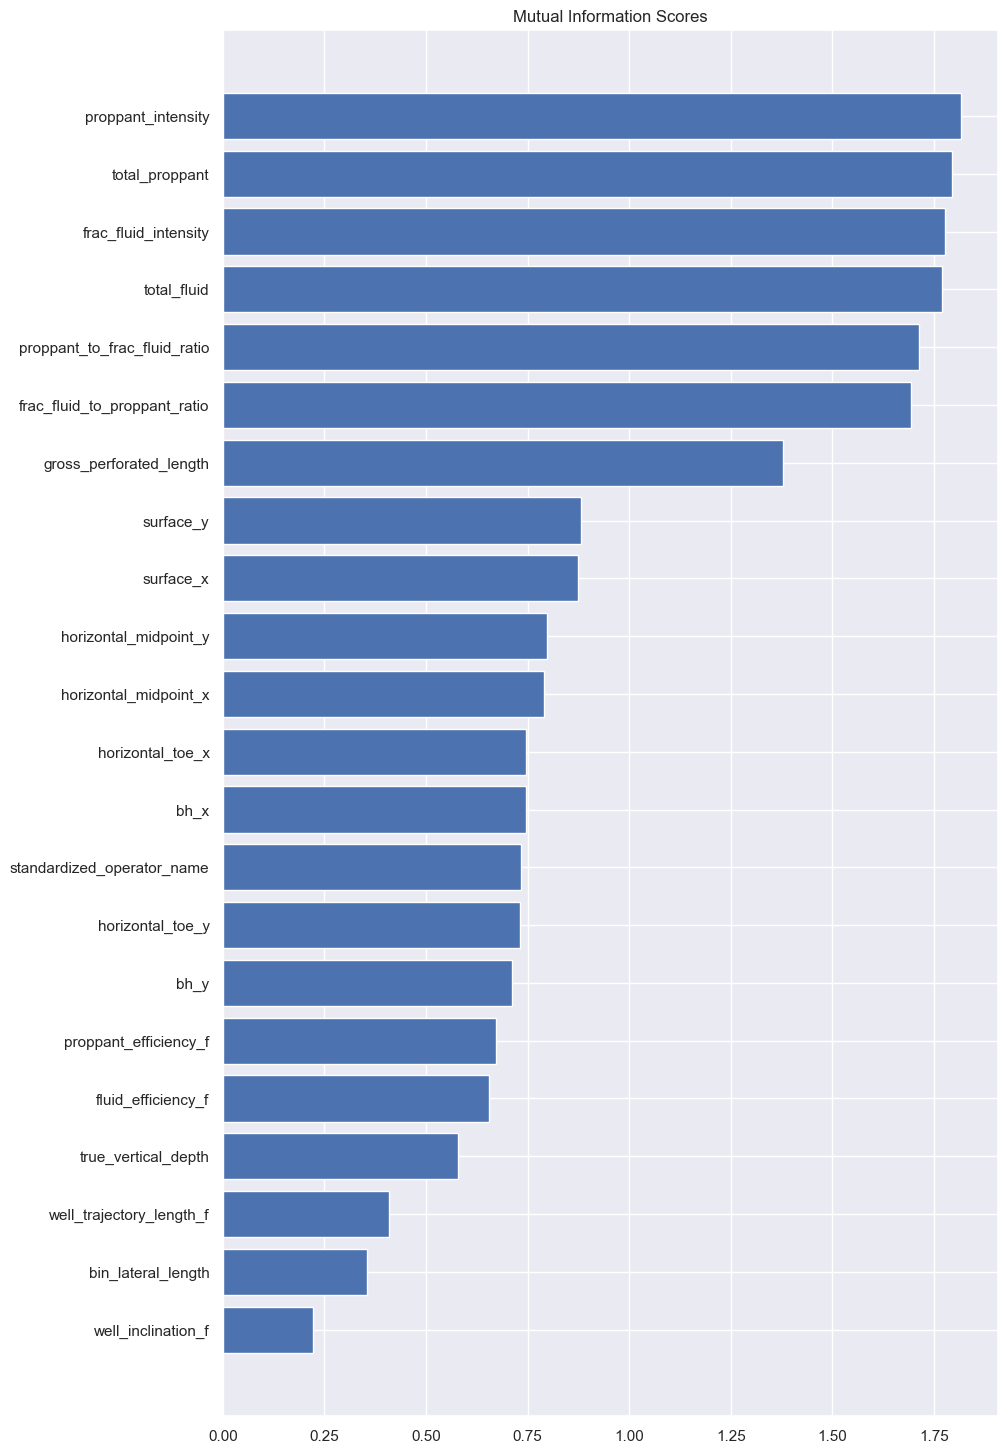

In [146]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# # Calculate mutual info scores
# mi_scores = mutual_info_regression(df.drop(columns='OilPeakRate'), df['OilPeakRate'])

# # Create a Series with scores and sort it
# mi_scores_series = pd.Series(mi_scores, index=df.drop(columns='OilPeakRate').columns)
# mi_scores_series.sort_values(ascending=False, inplace=True)

# # Plot the mutual info scores
# plt.figure(figsize=(10, 5))
# mi_scores_series.plot(kind='bar')
# plt.ylabel('Mutual Information Score')
# plt.show()


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


# Calculate mutual info scores
mi_scores = mutual_info_regression(
    df.drop(columns="OilPeakRate"), df["OilPeakRate"]
)

# Create a Series with scores
mi_scores_series = pd.Series(
    mi_scores, index=df.drop(columns="OilPeakRate").columns
)

plt.figure(dpi=100, figsize=(10, 18))
plot_mi_scores(mi_scores_series)


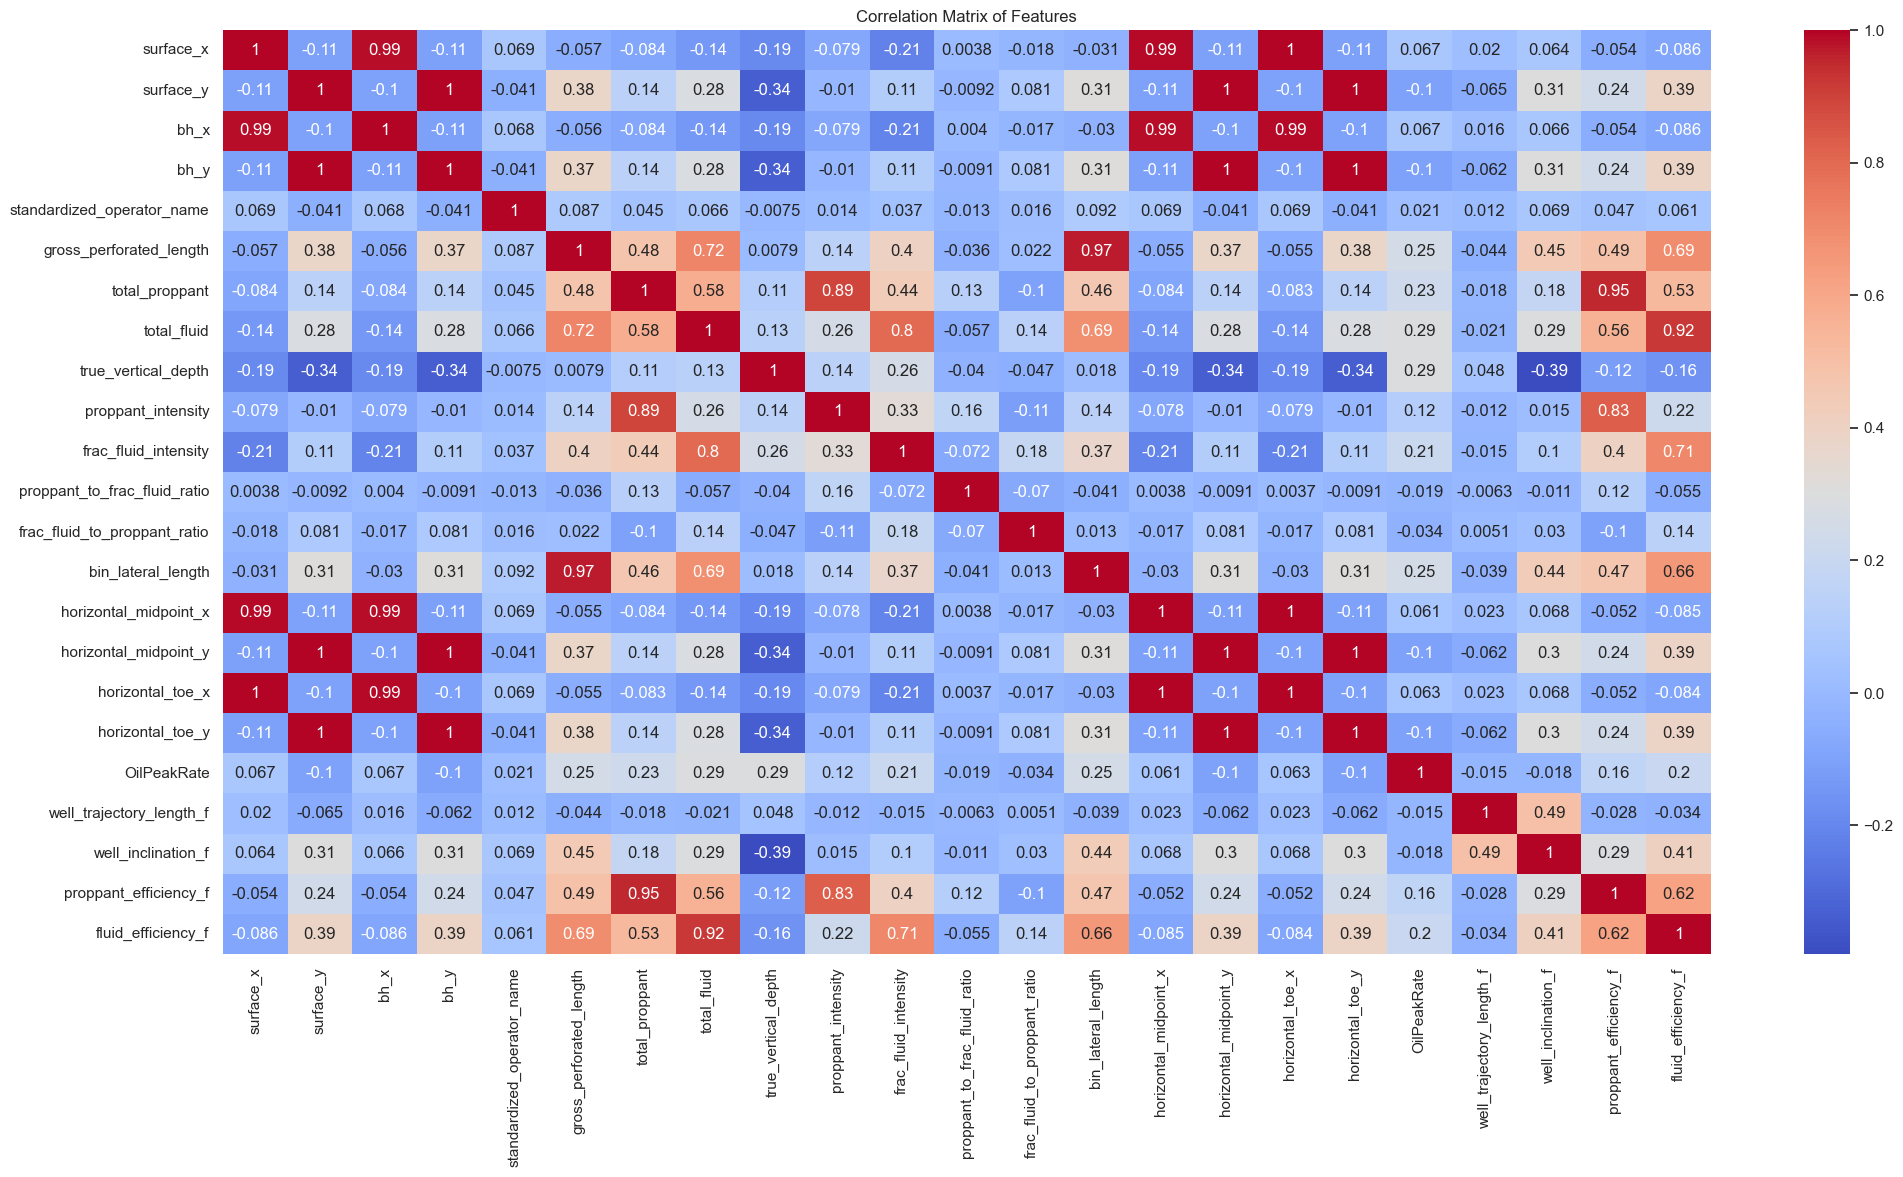

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns


# get the correlation matrix
corr_matrix = df.corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(24, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()


# Important Feature Selection


In [148]:
# Drop all rows except "OilPeakRate"
corr_matrix_copy = corr_matrix.copy().loc[["OilPeakRate"]]

corr_matrix_copy


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate,well_trajectory_length_f,well_inclination_f,proppant_efficiency_f,fluid_efficiency_f
OilPeakRate,0.0665,-0.1026,0.0669,-0.1032,0.0212,0.2497,0.2284,0.2947,0.2949,0.1175,0.2091,-0.0188,-0.0339,0.2523,0.0614,-0.1022,0.0626,-0.1020,1.0000,-0.0146,-0.0181,0.1623,0.2018


In [149]:
# Transpose corr_matrix_copy
corr_matrix_copy_transposed = corr_matrix_copy.T

corr_matrix_copy_transposed


,OilPeakRate
surface_x,0.0665
surface_y,-0.1026
bh_x,0.0669
bh_y,-0.1032
standardized_operator_name,0.0212
gross_perforated_length,0.2497
total_proppant,0.2284
total_fluid,0.2947
true_vertical_depth,0.2949
proppant_intensity,0.1175


In [150]:
# Sort mi_scores_series
mi_scores_series = mi_scores_series.sort_values(ascending=False)
mi_scores_series

# Convert mi_scores_series to a DataFrame
df_mi_scores = mi_scores_series.to_frame(name="mi_scores")

df_mi_scores

# # Reindex df_mi_scores to match the indices of corr_matrix_copy
# df_mi_scores = df_mi_scores.reindex(corr_matrix_copy.index)


,mi_scores
proppant_intensity,1.8166
total_proppant,1.7936
frac_fluid_intensity,1.7772
total_fluid,1.7698
proppant_to_frac_fluid_ratio,1.7124
frac_fluid_to_proppant_ratio,1.6944
gross_perforated_length,1.3776
surface_y,0.8816
surface_x,0.8736
horizontal_midpoint_y,0.7968


In [151]:
# Join corr_matrix_copy_transposed and mi_scores by columns
df_joined = pd.concat([corr_matrix_copy_transposed, df_mi_scores], axis=1)
df_joined


,OilPeakRate,mi_scores
surface_x,0.0665,0.8736
surface_y,-0.1026,0.8816
bh_x,0.0669,0.7472
bh_y,-0.1032,0.7107
standardized_operator_name,0.0212,0.7345
gross_perforated_length,0.2497,1.3776
total_proppant,0.2284,1.7936
total_fluid,0.2947,1.7698
true_vertical_depth,0.2949,0.5799
proppant_intensity,0.1175,1.8166


In [152]:
# Filter df_joined to only include rows where both columns are positive
positive_rows = df_joined[
    (df_joined["mi_scores"] > 0) & (df_joined["OilPeakRate"] > 0)
]

# Convert the index of positive_rows to a list
positive_rows_list = positive_rows.index.tolist()

# Remove 'standardized_operator_name' from positive_rows_list
if "standardized_operator_name" in positive_rows_list:
    positive_rows_list.remove("standardized_operator_name")


In [153]:
positive_rows_list


['surface_x',
 'bh_x',
 'gross_perforated_length',
 'total_proppant',
 'total_fluid',
 'true_vertical_depth',
 'proppant_intensity',
 'frac_fluid_intensity',
 'bin_lateral_length',
 'horizontal_midpoint_x',
 'horizontal_toe_x',
 'proppant_efficiency_f',
 'fluid_efficiency_f']

## Defining X_train_new, X_test_new for Model Training


In [154]:
# Create new train and test datasets using only the columns in positive_rows_list
X_train_new = X_train.loc[:, positive_rows_list]
X_test_new = X_test.loc[:, positive_rows_list]


In [155]:
# print X_train_new and X_test_new
X_train_new


,surface_x,bh_x,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,bin_lateral_length,horizontal_midpoint_x,horizontal_toe_x,proppant_efficiency_f,fluid_efficiency_f
29639,2.1843,2.1556,0.3180,-0.7010,-0.6308,-1.6213,-0.9089,-0.9299,0.3333,2.1794,2.1631,-0.3789,-0.3491
1606,0.3092,0.3427,0.4114,-0.5951,-0.6102,-1.1757,-0.9207,-1.0570,0.5000,0.3316,0.3430,-0.3470,-0.4231
6708,0.1872,0.2326,0.3017,0.0056,0.0434,0.8601,0.6938,0.5853,0.3333,0.2133,0.2335,-0.1893,-0.1449
10512,0.0657,0.0972,0.4334,-0.3521,0.0024,-0.0390,-0.5877,-0.1520,0.5000,0.0873,0.0976,-0.3275,0.0086
22819,-0.1175,-0.0819,0.5183,0.2850,0.9464,-0.4395,0.0462,0.8094,0.5000,-0.0949,-0.0821,0.4611,1.1436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,-1.1704,-1.1611,0.5141,-0.3534,-0.2515,0.3766,0.1568,0.1875,0.5000,-1.1644,-1.1651,-0.4022,-0.3062
5390,0.0349,0.0803,0.6102,0.2532,0.4529,-0.0884,-0.2538,-0.0936,0.6667,0.0624,0.0800,0.2823,0.4604
860,0.8871,0.8405,0.1255,-1.0801,-0.8183,-2.6093,-1.6840,-1.2259,0.0000,0.8969,0.8976,-1.0255,-0.4295
15795,0.5101,0.5322,0.2927,-0.4771,-0.4381,-0.2865,-0.3301,-0.4340,0.3333,0.5266,0.5347,-0.4063,-0.3775


In [156]:
X_test_new


,surface_x,bh_x,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,bin_lateral_length,horizontal_midpoint_x,horizontal_toe_x,proppant_efficiency_f,fluid_efficiency_f
18356,0.0279,0.0585,0.3433,-0.3351,-0.5097,0.2204,-0.2590,-0.7489,0.3333,0.0487,0.0586,-0.3598,-0.5130
25073,-1.4154,-1.3719,0.5052,1.2194,2.3464,0.3481,0.9652,2.1930,0.5000,-1.3917,-1.3765,0.9921,1.9548
18998,0.0272,-0.0006,0.4746,0.0900,0.2303,0.0690,-0.0652,0.0369,0.5000,0.0159,-0.0006,0.0715,0.1943
14028,-0.2917,-0.2708,0.2798,-0.8824,-0.8449,1.0056,-1.2306,-1.3397,0.3333,-0.2768,-0.2716,-0.8903,-0.8325
15918,0.7681,0.8006,0.4295,-0.2721,-0.2083,0.2868,-0.4535,-0.4628,0.5000,0.7915,0.8041,-0.3147,-0.2540
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,0.1513,0.1262,0.4150,-0.1281,-0.5007,0.3267,-0.1782,-0.8874,0.5000,0.1412,0.1271,-0.1941,-0.5160
13169,-0.4330,-0.3961,0.4849,-0.3676,-0.2487,-1.1211,-0.7287,-0.6518,0.5000,-0.4102,-0.3974,-0.0453,0.0607
27642,-0.5214,-0.5374,0.2640,-0.2423,0.0149,0.0350,0.4125,0.8309,0.3333,-0.5277,-0.5392,-0.2366,0.0018
124,0.0688,0.0583,0.2238,-0.8303,-0.7386,0.5537,-0.9546,-0.9996,0.3333,0.0686,0.0586,-0.8300,-0.7346


# Begin Model Training


In [157]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Dictionary of models
models = {
    "LinearRegression": LinearRegression(),
    "CatBoostRegressor": CatBoostRegressor(random_state=42, verbose=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "LGBMRegressor": LGBMRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
}

# Loop over models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_new, y_train)

    # Make predictions
    y_pred = model.predict(X_test_new)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error (RMSE) for {model_name}: {rmse}")


Root Mean Squared Error (RMSE) for LinearRegression: 0.693460368795157
Root Mean Squared Error (RMSE) for CatBoostRegressor: 0.4711995507652554
Root Mean Squared Error (RMSE) for GradientBoostingRegressor: 0.5898188083898503
Root Mean Squared Error (RMSE) for LGBMRegressor: 0.4953385665140331
Root Mean Squared Error (RMSE) for RandomForestRegressor: 0.43111241655130966
Root Mean Squared Error (RMSE) for DecisionTreeRegressor: 0.6256836111150759


In [158]:
# # using X_train_new and X_test_new

# Convert to PyTorch tensors (using new features)
X_train_tensor = torch.tensor(X_train_new.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_new.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ANN Model


class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Get the number of features in X_train_new
input_size = X_train_new.shape[1]

# Create the model
ann_model = ANNModel(input_size)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

# Training the Model
epochs = 200
best_test_rmse = float("inf")
best_epoch = -1

for epoch in range(epochs):
    ann_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = ann_model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

    ann_model.eval()
    # test_loss
    test_loss = 0
    with torch.no_grad():  # test_targets, test_outputs
        for test_inputs, test_targets in test_loader:
            test_outputs = ann_model(test_inputs)
            test_loss += criterion(
                test_outputs, test_targets.unsqueeze(1)
            ).item()
        test_loss /= len(test_loader)
        test_rmse = torch.sqrt(torch.tensor(test_loss))  # test_rmse

        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_epoch = epoch
            torch.save(ann_model.state_dict(), "best_model.pth")

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val RMSE: {test_rmse:.4f}"
            )

print(
    f"Best Epoch: {best_epoch+1}, Best Validation RMSE: {best_test_rmse.item():.4f}"
)

# Load the best model for further use or evaluation
ann_model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test data or any further steps
# ...


Epoch [10/200], Loss: 0.3667, Val RMSE: 0.6234
Epoch [20/200], Loss: 0.3789, Val RMSE: 0.6033
Epoch [30/200], Loss: 0.0614, Val RMSE: 0.5800
Epoch [40/200], Loss: 0.5418, Val RMSE: 0.5646
Epoch [50/200], Loss: 0.0994, Val RMSE: 0.5513
Epoch [60/200], Loss: 0.1073, Val RMSE: 0.5398
Epoch [70/200], Loss: 0.0902, Val RMSE: 0.5603
Epoch [80/200], Loss: 0.0498, Val RMSE: 0.5349
Epoch [90/200], Loss: 0.4263, Val RMSE: 0.5262
Epoch [100/200], Loss: 0.1816, Val RMSE: 0.5306
Epoch [110/200], Loss: 0.0717, Val RMSE: 0.5234
Epoch [120/200], Loss: 0.1700, Val RMSE: 0.5251
Epoch [130/200], Loss: 0.0967, Val RMSE: 0.5294
Epoch [140/200], Loss: 0.3499, Val RMSE: 0.5222
Epoch [150/200], Loss: 0.0796, Val RMSE: 0.5303
Epoch [160/200], Loss: 0.2828, Val RMSE: 0.5215
Epoch [170/200], Loss: 0.1438, Val RMSE: 0.5281
Epoch [180/200], Loss: 0.1542, Val RMSE: 0.5154
Epoch [190/200], Loss: 0.1462, Val RMSE: 0.5211
Epoch [200/200], Loss: 0.2383, Val RMSE: 0.5230
Best Epoch: 180, Best Validation RMSE: 0.5154


<All keys matched successfully>

# Hyperparameter Tuning


## LGBM Tuning


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
import pickle
import random

# Define the parameter grid
param_dist_lgbm = {
    "num_leaves": [5, 10, 15],
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [300, 500, 1000],
    "min_child_samples": [1, 5, 10],
}

# Define the number of iterations for RandomizedSearch
n_iter_search = 10

# Define the model
lgbm = LGBMRegressor(random_state=42)


# Define the scoring function
def scoring_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the scoring function to create a scorer
scorer = make_scorer(scoring_func, greater_is_better=False)

# Define the randomized search
random_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=n_iter_search,
    cv=5,
    scoring=scorer,
    random_state=42,
    n_jobs=-1,
)

# Fit the randomized search
random_search_lgbm.fit(X_train_new, y_train)

# Get the best parameters
best_params_lgbm = random_search_lgbm.best_params_

# Print the best parameters
print(f"Best parameters of LGBMRegressor: {best_params_lgbm}")
# Best parameters of LGBMRegressor: {'num_leaves': 10, 'n_estimators': 1000, 'min_child_samples': 5, 'learning_rate': 0.5}

# Save the random_search object to a file
with open("random_search_lgbm.pkl", "wb") as f:
    pickle.dump(random_search_lgbm, f)


### Output of LGBM Tuning

- [LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
- You can set `force_col_wise=true` to remove the overhead.
- [LightGBM] [Info] Total Bins 3066
- [LightGBM] [Info] Number of data points in the train set: 23753, number of used features: 13
- [LightGBM] [Info] Start training from score 0.153549
- Best parameters of LGBMRegressor: {'num_leaves': 10, 'n_estimators': 1000, 'min_child_samples': 5, 'learning_rate': 0.5}


## Catboost Tuning


In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define the parameter grid
param_grid = {
    "learning_rate": [0.035, 0.04, 0.045],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [2, 3, 4],
    "random_strength": [0.5, 0.75, 1],
    "iterations": [750, 1000, 1250],
}

# Define the model
ctbm = CatBoostRegressor(verbose=0, random_state=42, allow_writing_files=False)

# Define the scorer
scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False,
)

# Define the grid search
grid_search = GridSearchCV(ctbm, param_grid, cv=5, scoring=scorer)

# Fit the grid search
grid_search.fit(X_train_new, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f"Best parameters: {best_params}")
# Best parameters: {'depth': 8, 'iterations': 1250, 'l2_leaf_reg': 2, 'learning_rate': 0.045, 'random_strength': 1}


Best parameters: {'depth': 8, 'iterations': 1250, 'l2_leaf_reg': 2, 'learning_rate': 0.045, 'random_strength': 1}


In [86]:
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Use the model with the best parameters to make predictions on the test set
# y_pred = grid_search.best_estimator_.predict(X_test_new)

# # Calculate the RMSE of the predictions
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# # Print the RMSE
# print(f"RMSE: {rmse}")


RMSE: 0.44940931449991606


## RandomForest Tuning


In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import pickle

# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# Define the model
rf = RandomForestRegressor(random_state=42)


# Define the scoring function
def scoring_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the scoring function to create a scorer
scorer = make_scorer(scoring_func, greater_is_better=False)

# Define the grid search
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring=scorer, n_jobs=-1)

# Fit the grid search
grid_search_rf.fit(X_train_new, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_

# Print the best parameters
print(f"Best parameters of RandomForestRegressor: {best_params_rf}")

# import pickle

# Save the grid_search object to a file
with open("grid_search_rf.pkl", "wb") as f:
    pickle.dump(grid_search_rf, f)


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best parameters of RandomForestRegressor: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


# Model Comparison (RMSE)


In [89]:
models = {
    "CatBoostRegressor": CatBoostRegressor(
        random_state=42,
        verbose=0,
        depth=8,
        iterations=1250,
        l2_leaf_reg=2,
        learning_rate=0.045,
        random_strength=1,
    ),
    "LGBMRegressor": LGBMRegressor(
        random_state=42,
        num_leaves=10,
        n_estimators=1000,
        min_child_samples=5,
        learning_rate=0.5,
    ),
    "RandomForestRegressor": RandomForestRegressor(
        random_state=42,
        bootstrap=True,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=300,
    ),
}

# Loop over models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_new, y_train)

    # Make predictions
    y_pred = model.predict(X_test_new)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error (RMSE) for {model_name}: {rmse}")

    # Save the model to a file
    dump(model, f"{model_name}.joblib")


Root Mean Squared Error (RMSE) for CatBoostRegressor: 0.44940931449991606
Root Mean Squared Error (RMSE) for LGBMRegressor: 0.4691830598303514
Root Mean Squared Error (RMSE) for RandomForestRegressor: 0.42841531388340137


In [90]:
# Original RMSE Values (Without Hyperparameter Tuning):
# Root Mean Squared Error (RMSE) for CatBoostRegressor: 0.4711995507652554
# Root Mean Squared Error (RMSE) for LGBMRegressor: 0.4953385665140331
# Root Mean Squared Error (RMSE) for RandomForestRegressor: 0.43111241655130966

# RMSE Values After Hyperparameter Tuning:
# Root Mean Squared Error (RMSE) for CatBoostRegressor: 0.44940931449991606
# Root Mean Squared Error (RMSE) for LGBMRegressor: 0.4691830598303514
# Root Mean Squared Error (RMSE) for RandomForestRegressor: 0.42841531388340137

# Define the data
data = {
    "Model": ["CatBoostRegressor", "LGBMRegressor", "RandomForestRegressor"],
    "RMSE Before Tuning": [
        0.4711995507652554,
        0.4953385665140331,
        0.43111241655130966,
    ],
    "RMSE After Tuning": [
        0.44940931449991606,
        0.4691830598303514,
        0.42841531388340137,
    ],
}

# Create the DataFrame
df = pd.DataFrame(data)

df


,Model,RMSE Before Tuning,RMSE After Tuning
0,CatBoostRegressor,0.4712,0.4494
1,LGBMRegressor,0.4953,0.4692
2,RandomForestRegressor,0.4311,0.4284


In [91]:
# Add a new column for the difference in RMSE
df["RMSE Difference"] = df["RMSE Before Tuning"] - df["RMSE After Tuning"]


In [92]:
df


,Model,RMSE Before Tuning,RMSE After Tuning,RMSE Difference
0,CatBoostRegressor,0.4712,0.4494,0.0218
1,LGBMRegressor,0.4953,0.4692,0.0262
2,RandomForestRegressor,0.4311,0.4284,0.0027


- Root Mean Squared Error (RMSE) for LinearRegression: 0.693460368795157
- Root Mean Squared Error (RMSE) for CatBoostRegressor: 0.4711995507652554
- Root Mean Squared Error (RMSE) for GradientBoostingRegressor: 0.5898188083898503
- Root Mean Squared Error (RMSE) for LGBMRegressor: 0.4953385665140331
- Root Mean Squared Error (RMSE) for RandomForestRegressor: 0.43111241655130966
- Root Mean Squared Error (RMSE) for DecisionTreeRegressor: 0.6256836111150759
- ANN Best Validation RMSE: 0.5078


In [93]:
# Define the data

data = {
    "Model": [
        "LinearRegression",
        "CatBoostRegressor",
        "GradientBoostingRegressor",
        "LGBMRegressor",
        "RandomForestRegressor",
        "DecisionTreeRegressor",
        "ANN",
    ],
    "RMSE": [
        0.693460368795157,
        0.4711995507652554,
        0.5898188083898503,
        0.4953385665140331,
        0.43111241655130966,
        0.6256836111150759,
        0.5078,
    ],
}

# Create the DataFrame

df = pd.DataFrame(data)

df


,Model,RMSE
0,LinearRegression,0.6935
1,CatBoostRegressor,0.4712
2,GradientBoostingRegressor,0.5898
3,LGBMRegressor,0.4953
4,RandomForestRegressor,0.4311
5,DecisionTreeRegressor,0.6257
6,ANN,0.5078


# Preprocessing For Test Data


In [159]:
# Code to preprocess the test data and add new features


def process_csv(file_path):
    # Load the data
    df = pd.read_csv(file_path)

    # Create new features
    df["well_trajectory_length_f"] = np.sqrt(
        (df["surface_x"] - df["bh_x"]) ** 2
        + (df["surface_y"] - df["bh_y"]) ** 2
        + (df["true_vertical_depth"]) ** 2
    )

    df["well_inclination_f"] = np.arccos(
        df["true_vertical_depth"] / df["well_trajectory_length_f"]
    )

    df["proppant_efficiency_f"] = (
        df["total_proppant"] / df["true_vertical_depth"]
    )
    df["fluid_efficiency_f"] = df["total_fluid"] / df["true_vertical_depth"]

    # Define the columns to be scaled using MinMaxScaler and RobustScaler
    min_max_scaler_columns = [
        "standardized_operator_name",
        "bin_lateral_length",
        "horizontal_midpoint_y",
        "horizontal_toe_y",
        "gross_perforated_length",
        "surface_y",
        "bh_y",
    ]  # replace with your actual column names
    robust_scaler_columns = [
        "surface_x",
        "bh_x",
        "true_vertical_depth",
        "total_proppant",
        "total_fluid",
        "proppant_intensity",
        "frac_fluid_intensity",
        "proppant_to_frac_fluid_ratio",
        "frac_fluid_to_proppant_ratio",
        "well_trajectory_length_f",
        "well_inclination_f",
        "proppant_efficiency_f",
        "fluid_efficiency_f",
        "horizontal_midpoint_x",
        "horizontal_toe_x",
    ]

    # Scale the columns
    min_max_scaler = pp.MinMaxScaler()
    robust_scaler = pp.RobustScaler()

    for column in min_max_scaler_columns:
        df[column] = min_max_scaler.fit_transform(df[[column]].values)

    for column in robust_scaler_columns:
        df[column] = robust_scaler.fit_transform(df[[column]].values)

    selected_columns = [
        "surface_x",
        "bh_x",
        "gross_perforated_length",
        "total_proppant",
        "total_fluid",
        "true_vertical_depth",
        "proppant_intensity",
        "frac_fluid_intensity",
        "bin_lateral_length",
        "horizontal_midpoint_x",
        "horizontal_toe_x",
        "proppant_efficiency_f",
        "fluid_efficiency_f",
    ]
    df = df[selected_columns]

    return df


In [165]:
# Load the model from the file
# model = load("RandomForestRegressor.joblib")
model = load("CatBoostRegressor.joblib")
# model = load("LGBMRegressor.joblib")


# Assume new_data is your new data on which you want to make predictions
new_data = process_csv("scoring.csv")

# Use the loaded model to make predictions on the new data
predictions = model.predict(new_data)
# Inverse transform the predictions to the original scale
predictions_orig = OilPeakRate.inverse_transform(predictions.reshape(-1, 1))

# # Calculate RMSE on the original scale
# rmse = np.sqrt(mean_squared_error(compare_col, predictions_orig.flatten()))

# print(f"Root Mean Squared Error (RMSE): {rmse}")

# Print the predictions


In [113]:
# Create a DataFrame with the RMSE
df = pd.DataFrame(predictions_orig, columns=["OilPeakRate"])

# Write the DataFrame to an Excel file
df.to_excel("submission_file.xlsx", index=False)


In [ ]:
# Add prediction code
